# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [85]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [86]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int, num_components):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    
    #x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    #b = np.zeros_like(x_random)
    #x = hm.solve.run.run_iterative_method(
    #    level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    #start, end = 0, aggregate_size
    #x_aggregate_t = x[start:end].transpose()
    #print(x_aggregate_t.shape)
    #r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [87]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [88]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

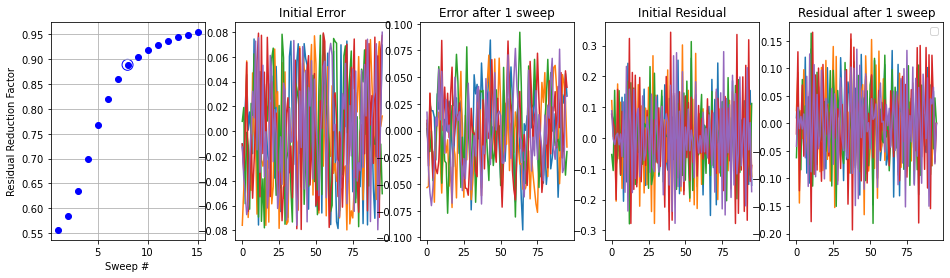

In [89]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [90]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 30 sweeps
INFO     RER 0.192


### Coarsening: Fixed (4/2)

In [91]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3
0,-0.2912,-0.4987,-0.5966,-0.5573
1,0.7292,0.3566,-0.1202,-0.5715


nu 100 s [1.    0.42  0.028 0.003] Energy error [0.388 0.026 0.003 0.   ]
INFO     Mock cycle conv [0.606 0.331 0.186 0.142 0.145 0.13  0.088 0.065 0.065 0.059 0.054]


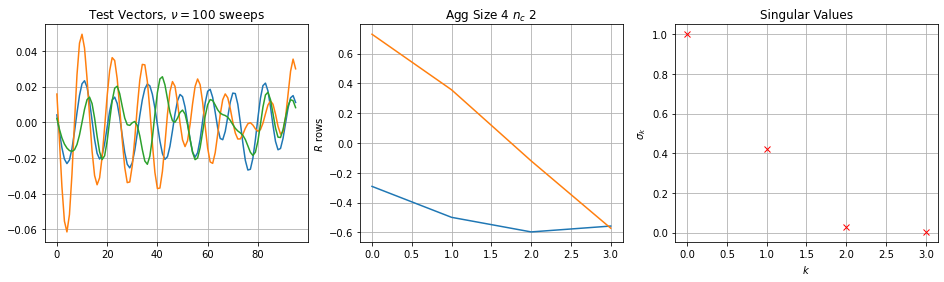

In [92]:
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.3785,-0.5302,-0.5795,-0.4896,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6580,0.3259,-0.1734,-0.6563,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.3785,-0.5302,-0.5795,-0.4896,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6580,0.3259,-0.1734,-0.6563,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.3785,-0.5302


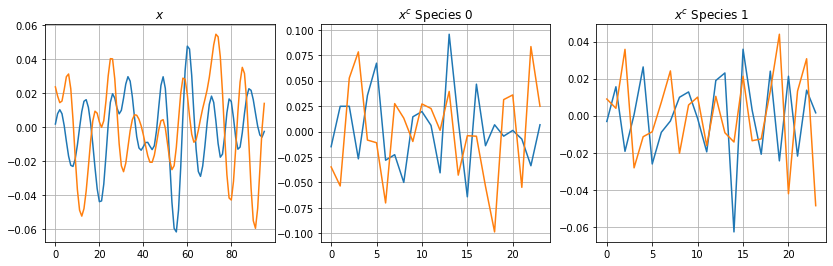

In [93]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [94]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.536 0.307 0.164 0.122 0.142 0.105 0.085 0.066]


### Interpolation $P = R^T$

In [95]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.79


### Interpolation by LS Fitting

In [96]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.54,0.31,0.16,0.12,0.14,0.10,0.08,0.07
P=R^T,nan,nan,nan,nan,nan,0.54,0.39,0.48,0.48,0.45,0.45,0.44,0.43
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.53,0.36,0.44,0.48,0.42,0.41,0.42,0.40
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.62,0.32,0.27,0.32,0.31,0.26,0.23,0.23
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.33,0.21,0.15,0.16,0.14,0.10,0.08
R A P caliber 2,1.00,2.00,192.00,1.20,0.04,0.53,0.38,0.46,0.48,0.42,0.40,0.42,0.40
R A P caliber 3,1.00,3.00,288.00,1.20,0.02,0.61,0.33,0.27,0.33,0.30,0.26,0.26,0.26
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.69,0.37,0.29,0.21,0.16,0.14,0.10,0.07


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [97]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.3757,0.6809
1,-0.5347,0.2953
2,-0.5762,-0.1844
3,-0.4904,-0.6356


A^1


,0,1,2,3,4,5
0,-0.1941,-0.1186,0.2058,-0.4005,0.2058,0.2843
1,-0.1186,-1.4456,0.2843,-0.5510,-0.4005,-0.5510


caliber 3 P


,0,1,2,3
0,-0.3867,0.5554,0.0000,-0.0840
1,-0.5272,0.3925,0.0000,0.0602
2,-0.5777,-0.2794,0.0567,0.0000
3,-0.4889,-0.5298,-0.0632,0.0000


A^1


,0,1,2,3,4,5,6,7
0,-0.0910,-0.0825,0.1732,-0.2892,0.0053,0.0053,0.1732,0.2142
1,-0.0825,-1.0840,0.2142,-0.3620,0.0000,0.0000,-0.2892,-0.3620


caliber 4 P


,0,1,2,3,4,5
0,-0.3421,0.4493,0.0000,0.0000,-0.1306,-0.1690
1,-0.5563,0.4619,0.0000,0.0000,0.0907,0.1105
2,-0.6271,-0.3719,0.0778,-0.1284,0.0000,0.0000
3,-0.4297,-0.4190,-0.0884,0.1537,0.0000,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.0728,-0.0693,0.1579,-0.2698,0.0109,-0.0181,0.0109,0.0134,0.1579,0.1995
1,-0.0693,-0.9664,0.1995,-0.3450,0.0134,-0.0221,-0.0181,-0.0221,-0.2698,-0.3450


R*A*P
caliber 2 P


,0,1
0,-0.3757,0.6809
1,-0.5347,0.2953
2,-0.5762,-0.1844
3,-0.4904,-0.6356


A^1


,0,1,2,3,4,5
0,-0.1943,-0.1141,0.2053,-0.3996,0.2077,0.2869
1,-0.1319,-1.4432,0.2941,-0.5699,-0.3854,-0.5303


caliber 3 P


,0,1,2,3
0,-0.3867,0.5554,0.0000,-0.0840
1,-0.5272,0.3925,0.0000,0.0602
2,-0.5777,-0.2794,0.0567,0.0000
3,-0.4889,-0.5298,-0.0632,0.0000


A^1


,0,1,2,3,4,5
0,-0.1119,-0.1008,0.1872,-0.3197,0.1881,0.2351
1,-0.1003,-1.1803,0.2217,-0.4565,-0.3001,-0.4351


caliber 4 P


,0,1,2,3,4,5
0,-0.3421,0.4493,0.0000,0.0000,-0.1306,-0.1690
1,-0.5563,0.4619,0.0000,0.0000,0.0907,0.1105
2,-0.6271,-0.3719,0.0778,-0.1284,0.0000,0.0000
3,-0.4297,-0.4190,-0.0884,0.1537,0.0000,0.0000


A^1


,0,1,2,3,4,5
0,-0.0371,-0.0487,0.1492,-0.1923,0.1490,0.1439
1,-0.0490,-0.6418,0.1492,-0.1625,-0.2005,-0.1669


In [98]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.831e+01 RER 3.40889
INFO         1 |r| 3.903e+00 (0.21320) RER 0.09129 (0.02678) 42.752
INFO         2 |r| 9.472e-01 (0.24271) RER 0.02388 (0.26158) 39.666
INFO         3 |r| 1.745e-01 (0.18427) RER 0.00454 (0.19018) 38.432
INFO         4 |r| 5.313e-02 (0.30437) RER 0.00137 (0.30242) 38.680
INFO         5 |r| 1.123e-02 (0.21132) RER 0.00029 (0.21138) 38.668
INFO         6 |r| 3.264e-03 (0.29073) RER 0.00008 (0.29078) 38.661
INFO         7 |r| 8.696e-04 (0.26644) RER 0.00002 (0.26643) 38.662
INFO         8 |r| 2.150e-04 (0.24721) RER 0.00001 (0.24721) 38.662
INFO         9 |r| 6.343e-05 (0.29506) RER 0.00000 (0.29506) 38.662
INFO        10 |r| 1.649e-05 (0.26001) RER 0.00000 (0.26001) 38.662
INFO        11 |r| 4.787e-06 (0.29021) RER 0.00000 (0.29021) 38.662
INFO        12 |r| 1.384e-06 (0.28910) RER 0.00000 (0.28910) 38.662
INFO        13 |r| 3.934e-07 (0.28425) RER 0.00000 (0.28425) 38.662
INFO        14 |r| 1.151e-07 (0.29257) RER 0.00000 (0.29257) 38.662
INFO   

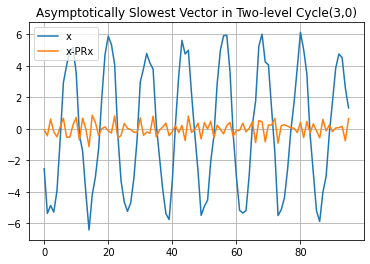

In [99]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].p.dot(m0[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [100]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.167  0.167]


In [101]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 288 stored elements in Compressed Sparse Row format>

In [102]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,-0.0371,-0.0487,0.1492,-0.1923,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0490,-0.6418,0.1492,-0.1625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.1490,0.1439,-0.0371,-0.0487,0.1492,-0.1923,0.0000,0.0000,0.0000,0.0000
3,-0.2005,-0.1669,-0.0490,-0.6418,0.1492,-0.1625,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.1490,0.1439,-0.0371,-0.0487,0.1492,-0.1923,0.0000,0.0000
5,0.0000,0.0000,-0.2005,-0.1669,-0.0490,-0.6418,0.1492,-0.1625,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.1490,0.1439,-0.0371,-0.0487,0.1492,-0.1923
7,0.0000,0.0000,0.0000,0.0000,-0.2005,-0.1669,-0.0490,-0.6418,0.1492,-0.1625
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1490,0.1439,-0.0371,-0.0487
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2005,-0.1669,-0.0490,-0.6418


In [103]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0003,0.0002,0.0082,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0003,0.0000,0.0052,0.0044,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0002,-0.0052,0.0000,0.0003,0.0002,0.0082,0.0000,0.0000,0.0000,0.0000
3,-0.0082,-0.0044,-0.0003,0.0000,0.0052,0.0044,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0002,-0.0052,0.0000,0.0003,0.0002,0.0082,0.0000,0.0000
5,0.0000,0.0000,-0.0082,-0.0044,-0.0003,0.0000,0.0052,0.0044,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0052,0.0000,0.0003,0.0002,0.0082
7,0.0000,0.0000,0.0000,0.0000,-0.0082,-0.0044,-0.0003,0.0000,0.0052,0.0044
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0052,0.0000,0.0003
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0082,-0.0044,-0.0003,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [104]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [105]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.620e-01                    4.456e-01    0.590
INFO     1     9.104e-02 (0.346) [0.346]    2.593e-01    0.351 (0.598)
INFO     2     5.345e-02 (0.591) [0.452]    1.947e-01    0.276 (0.788)
INFO     3     3.199e-02 (0.596) [0.496]    1.654e-01    0.195 (0.704)
INFO     4     2.404e-02 (0.756) [0.551]    1.470e-01    0.166 (0.852)
INFO     5     1.876e-02 (0.782) [0.590]    1.345e-01    0.141 (0.856)
INFO     6     1.538e-02 (0.821) [0.624]    1.256e-01    0.124 (0.880)
INFO     7     1.309e-02 (0.851) [0.652]    1.188e-01    0.112 (0.901)
INFO     8     1.149e-02 (0.876) [0.677]    1.133e-01    0.102 (0.919)
INFO     9     1.031e-02 (0.895) [0.698]    1.087e-01    0.096 (0.933)
INFO     10    9.398e-03 (0.909) [0.717]    1.048e-01    0.090 (0.943)
INFO     11    8.661e-03 (0.919) [0.734]    1.014e-01    0.086 (0.950)
INFO     12    8.046e-03 (0.926) [0.748]    9.829e-02    0.082 (0.955)
INFO 

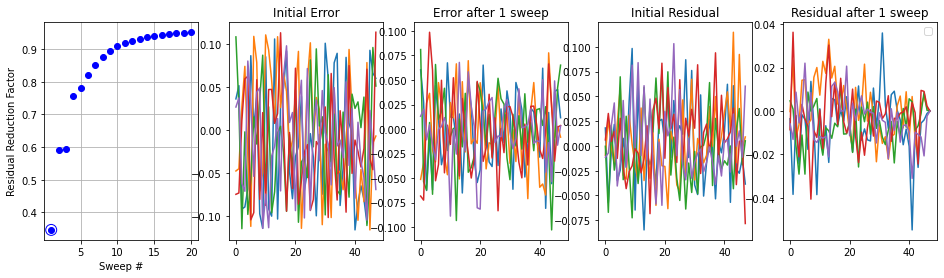

In [106]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,0.6000,0.2261,-0.3408,-0.6876
1,0.1266,0.6789,0.7228,-0.0246


nu 100 s [1.    0.616 0.333 0.221] Energy error [0.592 0.322 0.179 0.   ]
INFO     Mock cycle conv [0.437 0.313 0.241 0.205 0.152 0.15  0.143 0.136 0.13  0.125 0.122]


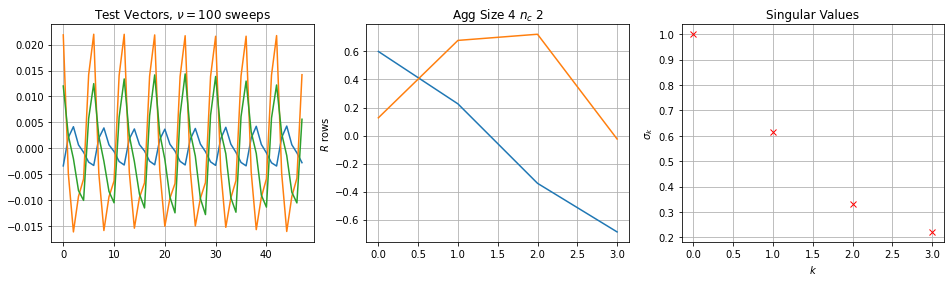

In [107]:
# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [108]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1490,0.1439,-0.0371,-0.0487,0.1492,-0.1923
1,-0.2005,-0.1669,-0.0490,-0.6418,0.1492,-0.1625


In [109]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.003


In [110]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [111]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [112]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.896 0.269 0.167]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,-0.6426,-0.1666,0.5503,0.5065,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0067,-0.7055,-0.5870,0.3972,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.6426,-0.1666,0.5503,0.5065,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.0067,-0.7055,-0.5870,0.3972,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6426,-0.1666


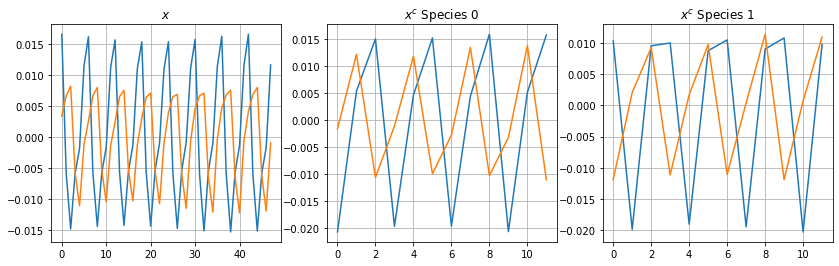

In [113]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [114]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.453 0.441 0.388 0.32  0.278 0.238 0.199 0.163 0.133 0.116 0.098]


In [115]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [116]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.57


### Interpolation by LS Fitting

In [117]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.45,0.44,0.39,0.32,0.28,0.24,0.20,0.16,0.13,0.12,0.10
P=R^T,nan,nan,nan,nan,nan,1.25,0.99,0.88,0.91,0.95,1.00,1.00,1.00,1.00,1.00,1.00
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,6.75,4.49,3.54,3.48,2.98,2.53,2.15,1.81,1.52,1.27,1.03
P^T A P caliber 3,0.00,3.00,144.00,1.17,0.00,0.27,0.13,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.01,0.01
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,0.54,0.24,0.13,0.12,0.09,0.06,0.03,0.03,0.03,0.02,0.02
R A P caliber 2,1.00,2.00,96.00,1.00,0.08,1.99,1.54,1.36,1.19,1.04,0.90,0.74,0.64,0.63,0.56,0.54
R A P caliber 3,1.00,3.00,144.00,1.00,0.07,52.13,8.53,11.84,3.61,0.38,0.30,0.27,0.33,0.36,0.37,0.38
R A P caliber 4,1.00,4.00,192.00,1.00,0.02,0.36,0.19,0.16,0.14,0.11,0.10,0.10,0.09,0.07,0.06,0.06


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 3.549e+00 RER 0.81818
INFO         1 |r| 6.826e-01 (0.19236) RER 0.04911 (0.06003) 13.899
INFO         2 |r| 9.461e-02 (0.13859) RER 0.01767 (0.35969) 5.355
INFO         3 |r| 1.266e-02 (0.13378) RER 0.00289 (0.16339) 4.385
INFO         4 |r| 3.616e-03 (0.28571) RER 0.00085 (0.29511) 4.245
INFO         5 |r| 8.554e-04 (0.23654) RER 0.00020 (0.23694) 4.238
INFO         6 |r| 1.584e-04 (0.18513) RER 0.00004 (0.18511) 4.238
INFO         7 |r| 2.455e-05 (0.15501) RER 0.00001 (0.15499) 4.239
INFO         8 |r| 5.048e-06 (0.20564) RER 0.00000 (0.20563) 4.239
INFO         9 |r| 1.075e-06 (0.21294) RER 0.00000 (0.21294) 4.239
INFO        10 |r| 2.118e-07 (0.19708) RER 0.00000 (0.19708) 4.239
INFO        11 |r| 4.276e-08 (0.20188) RER 0.00000 (0.20188) 4.239
INFO        12 |r| 6.657e-09 (0.15566) RER 0.00000 (0.15566) 4.239
INFO        13 |r| 1.344e-09 (0.20194) RER 0.00000 (0.20194) 4.239
INFO        14 |r| 2.718e-10 (0.20219) RER 0.00000 (0.20219) 4.239
INFO        15 |r| 4

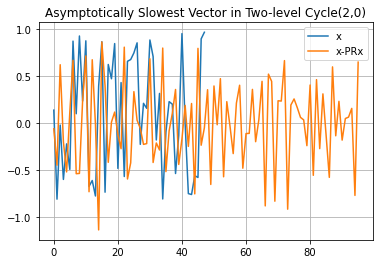

In [118]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [119]:
m1[1].a

<24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [120]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.167  0.167]
1 lam [-0.    -0.     0.068  0.068  0.075  0.088  0.088 -0.091 -0.091  0.094  0.124  0.124]


## 3-Level Method

In [121]:
m0.add(m1[1])

INFO         0 |r| 1.777e+01 RER 3.16316
INFO         1 |r| 1.421e+00 (0.07996) RER 0.04834 (0.01528) 29.391
INFO         2 |r| 1.757e-01 (0.12363) RER 0.00655 (0.13541) 26.835
INFO         3 |r| 2.450e-02 (0.13945) RER 0.00091 (0.13911) 26.902
INFO         4 |r| 3.652e-03 (0.14909) RER 0.00014 (0.14914) 26.893
INFO         5 |r| 5.718e-04 (0.15655) RER 0.00002 (0.15655) 26.893
INFO         6 |r| 9.012e-05 (0.15763) RER 0.00000 (0.15762) 26.893
INFO         7 |r| 1.460e-05 (0.16196) RER 0.00000 (0.16196) 26.893
INFO         8 |r| 2.378e-06 (0.16291) RER 0.00000 (0.16291) 26.893
INFO         9 |r| 3.833e-07 (0.16120) RER 0.00000 (0.16120) 26.893
INFO        10 |r| 6.397e-08 (0.16689) RER 0.00000 (0.16689) 26.893
INFO        11 |r| 1.046e-08 (0.16358) RER 0.00000 (0.16358) 26.893
INFO        12 |r| 1.628e-09 (0.15561) RER 0.00000 (0.15561) 26.893
INFO        13 |r| 2.648e-10 (0.16260) RER 0.00000 (0.16260) 26.893
INFO        14 |r| 4.482e-11 (0.16929) RER 0.00000 (0.16929) 26.893


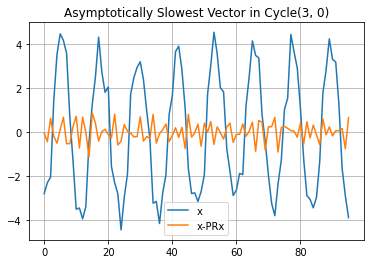

In [122]:
nu_pre = 3
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [123]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.167  0.167]
2 lam [-0.    -0.     0.068  0.068  0.075  0.088  0.088 -0.091 -0.091  0.094  0.124  0.124]


In [124]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

In [127]:
pd.DataFrame(m1[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0320,-0.0536,-0.0719,-0.1271,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0371,0.0485,0.0048,-0.0667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0567,-0.0072,0.0320,-0.0536,-0.0719,-0.1271,0.0000,0.0000,0.0000,0.0000
3,-0.1219,-0.0759,-0.0371,0.0485,0.0048,-0.0667,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0567,-0.0072,0.0320,-0.0536,-0.0719,-0.1271,0.0000,0.0000
5,0.0000,0.0000,-0.1219,-0.0759,-0.0371,0.0485,0.0048,-0.0667,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0567,-0.0072,0.0320,-0.0536,-0.0719,-0.1271
7,0.0000,0.0000,0.0000,0.0000,-0.1219,-0.0759,-0.0371,0.0485,0.0048,-0.0667
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0567,-0.0072,0.0320,-0.0536
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1219,-0.0759,-0.0371,0.0485


In [129]:
pd.DataFrame((m1[1].a - m1[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0165,-0.0152,-0.0051,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0165,0.0000,0.0120,0.0093,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0152,-0.0120,0.0000,-0.0165,-0.0152,-0.0051,0.0000,0.0000,0.0000,0.0000
3,0.0051,-0.0093,0.0165,0.0000,0.0120,0.0093,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0152,-0.0120,0.0000,-0.0165,-0.0152,-0.0051,0.0000,0.0000
5,0.0000,0.0000,0.0051,-0.0093,0.0165,0.0000,0.0120,0.0093,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0152,-0.0120,0.0000,-0.0165,-0.0152,-0.0051
7,0.0000,0.0000,0.0000,0.0000,0.0051,-0.0093,0.0165,0.0000,0.0120,0.0093
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0152,-0.0120,0.0000,-0.0165
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0051,-0.0093,0.0165,0.0000
